"""
Student Performance Data Analysis Portfolio

Author: YI LUO
Date: 20250324

Data Source:
https://www.kaggle.com/datasets/spscientist/students-performance-in-exams

Introduction:
This portfolio demonstrates a structured approach to analyzing a student performance dataset that includes scores from math, reading, and writing exams, along with key demographic and socioeconomic indicators. The goal is to uncover factors influencing academic outcomes and provide insights that can help tailor educational interventions, such as those implemented in programs like GEAR UP.

What We Did:
1. Data Import and Cleaning:
   - Loaded the dataset and reviewed its structure and summary statistics.
   - Checked for missing values and verified data types to ensure data quality.

2. Feature Engineering:
   - Created a new "total score" feature by summing math, reading, and writing scores.
   - Encoded categorical variables using LabelEncoder for nominal data and an ordinal mapping for parental education, preserving the natural ranking.

3. Exploratory Data Analysis (EDA):
   - Visualized the distributions of individual exam scores and the total score using histograms.
   - Created boxplots to compare scores across key categorical groups (gender, lunch type, and test preparation), highlighting socioeconomic differences.
   - Generated a correlation heatmap to explore relationships between scores and encoded features.

4. Modeling and Evaluation:
   - Split the data into training and validation sets.
   - Built predictive models using Random Forest regression (via MultiOutputRegressor) to predict individual exam scores and the total score.
   - Performed grid search to optimize model parameters and evaluated model performance with Mean Squared Error (MSE) and R² metrics.
   - Visualized feature importances for each target to understand the factors driving predictions.

5. Statistical Testing:
   - Conducted an independent two-sample t-test to examine the effect of socioeconomic status (proxied by lunch type) on math scores.
   - Found statistically significant differences indicating that students with free/reduced lunch tend to score lower, emphasizing the impact of socioeconomic factors.

Key Findings:
- Socioeconomic status has a significant effect on academic performance; students receiving free/reduced lunch scored lower than those with standard lunch.
- Structured test preparation is positively associated with improved exam scores.
- Higher parental education correlates with better student performance, suggesting the importance of parental involvement in education.

This analysis not only demonstrates technical expertise in data cleaning, visualization, feature engineering, and predictive modeling but also offers actionable insights for enhancing educational programs and targeted interventions.
"""

In [1]:
# Section 1: Data Import and Overview
import pandas as pd

# Load the student performance dataset
student_data = pd.read_csv('/Users/luoyi/Desktop/10_kaggle/07_student/StudentsPerformance.csv')

# Display the first few rows to inspect the data structure
print("First 5 rows of the dataset:")
print(student_data.head())

# Get a summary of the dataset (data types, non-null counts)
print("\nDataset Info:")
print(student_data.info())

# Get descriptive statistics for numerical columns
print("\nDescriptive Statistics for Scores:")
print(student_data[['math score', 'reading score', 'writing score']].describe())

First 5 rows of the dataset:
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Colum

In [2]:
# Section 2: Data Cleaning and Preprocessing

# Check for missing values in each column
missing_values = student_data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Confirm data types for further processing
print("\nData Types:")
print(student_data.dtypes)


Missing values in each column:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Data Types:
gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object


In [3]:
# Section 3: Feature Engineering

# --- 3.1 Create Total Score ---
# Sum the math, reading, and writing scores to create a comprehensive measure.
student_data['total score'] = student_data[['math score', 'reading score', 'writing score']].sum(axis=1)
print("\nData with 'total score':")
print(student_data[['math score', 'reading score', 'writing score', 'total score']].head())

# --- 3.2 Encode Categorical Variables ---
from sklearn.preprocessing import LabelEncoder

# List of nominal categorical variables (no inherent order)
nominal_vars = ['gender', 'race/ethnicity', 'lunch', 'test preparation course']
encoder = LabelEncoder()
for var in nominal_vars:
    student_data[var + '_encoded'] = encoder.fit_transform(student_data[var])

# Ordinal encoding for 'parental level of education' based on natural ranking
education_order = {
    "some high school": 1,
    "high school": 2,
    "some college": 3,
    "associate's degree": 4,
    "bachelor's degree": 5,
    "master's degree": 6
}
student_data['parental_education_encoded'] = student_data['parental level of education'].map(education_order)

print("\nData after encoding (showing a few columns):")
print(student_data[['gender', 'gender_encoded', 
                    'parental level of education', 'parental_education_encoded']].drop_duplicates())


Data with 'total score':
   math score  reading score  writing score  total score
0          72             72             74          218
1          69             90             88          247
2          90             95             93          278
3          47             57             44          148
4          76             78             75          229

Data after encoding (showing a few columns):
    gender  gender_encoded parental level of education  \
0   female               0           bachelor's degree   
1   female               0                some college   
2   female               0             master's degree   
3     male               1          associate's degree   
4     male               1                some college   
5   female               0          associate's degree   
8     male               1                 high school   
9   female               0                 high school   
15  female               0            some high school   
18    

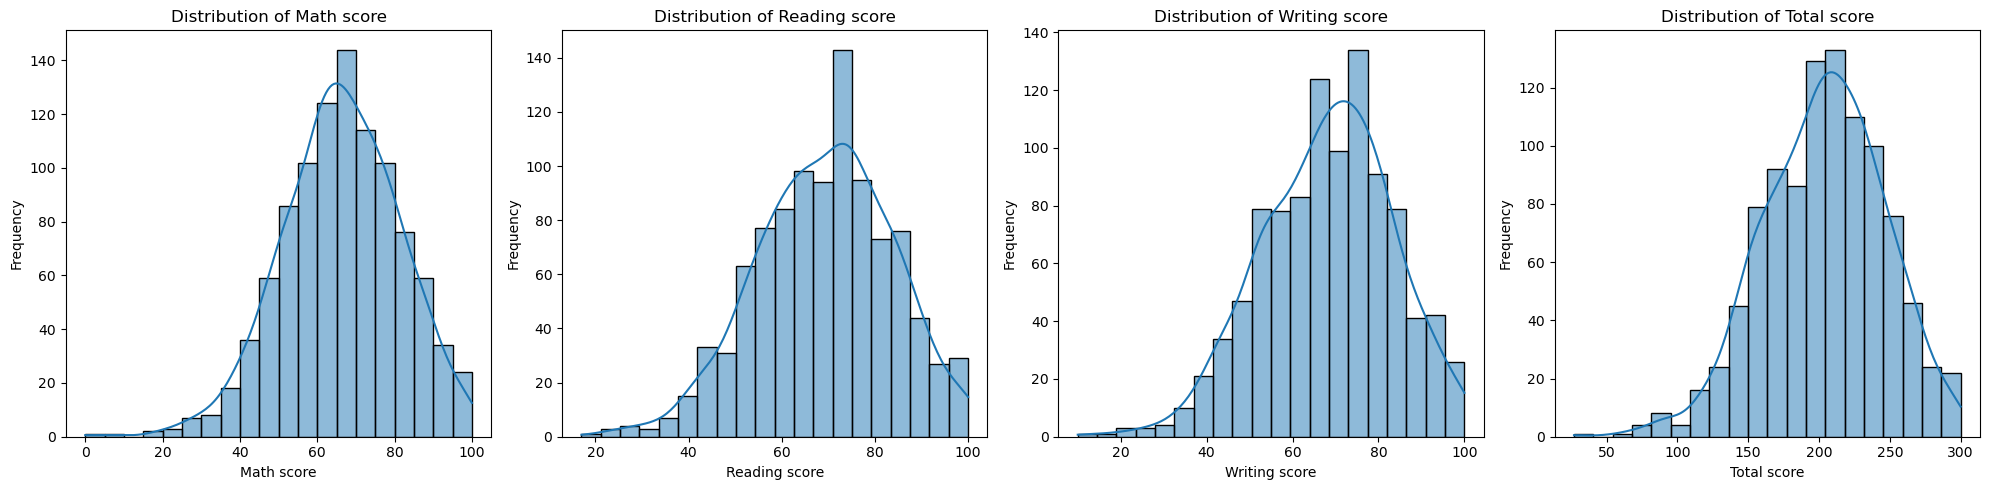

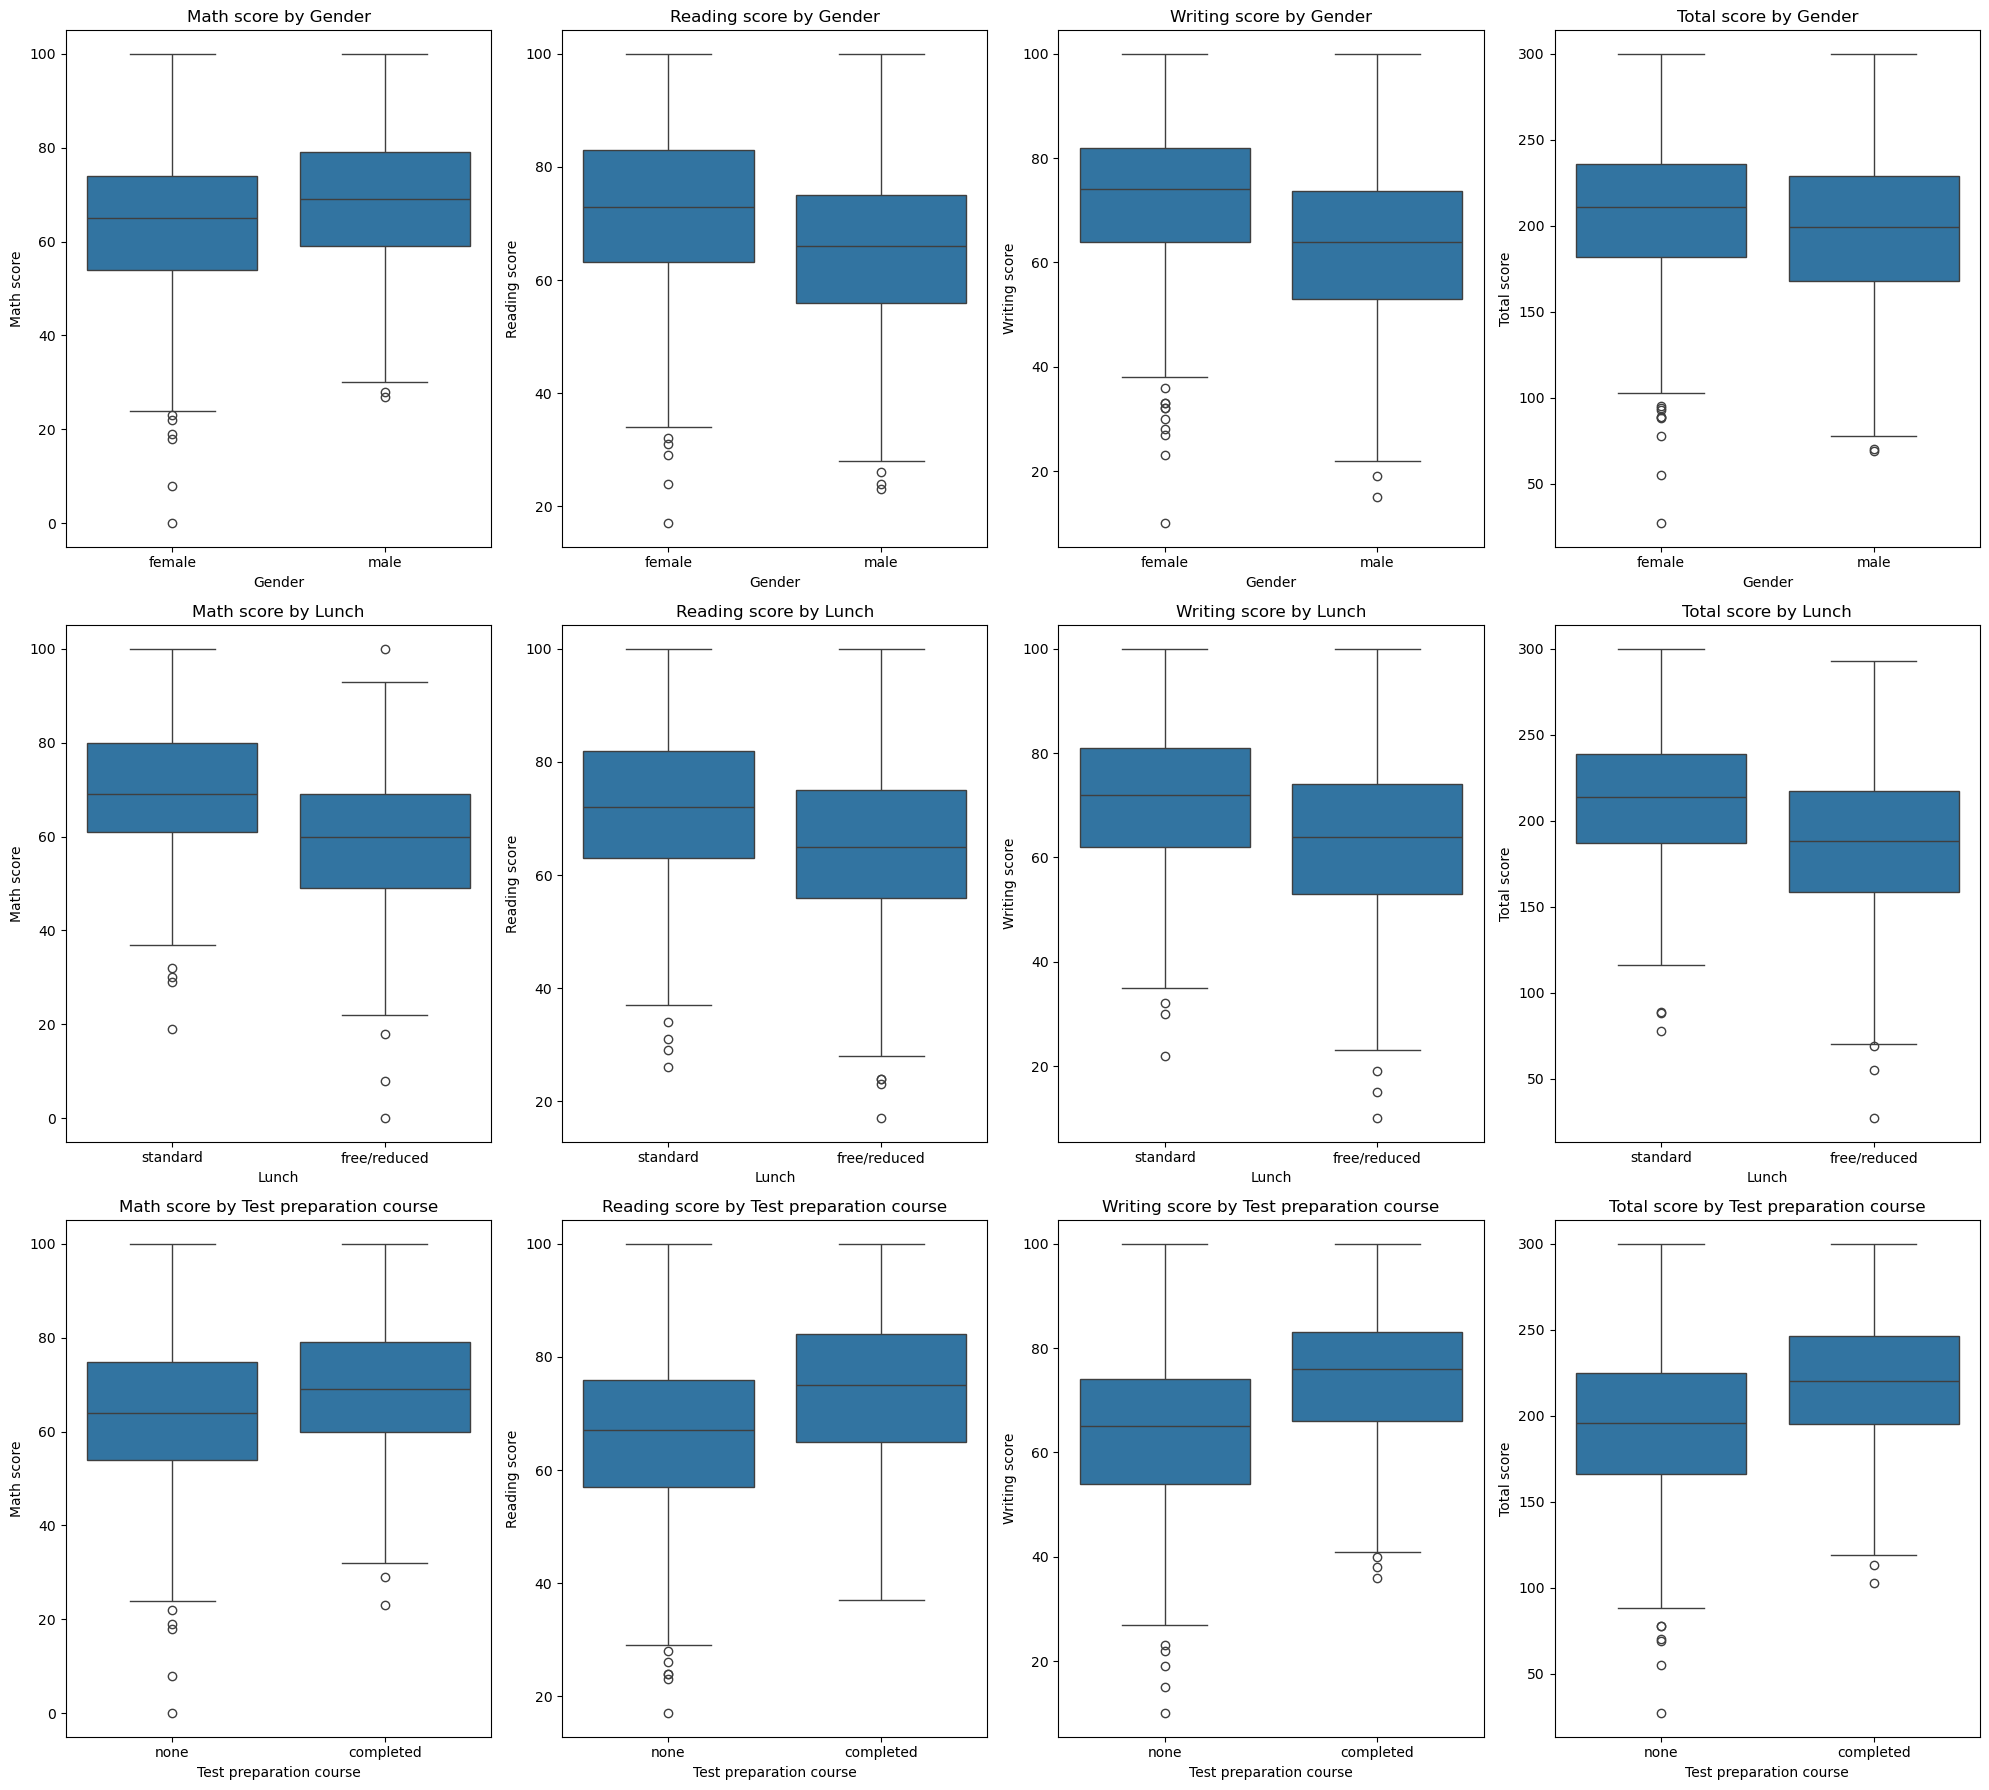

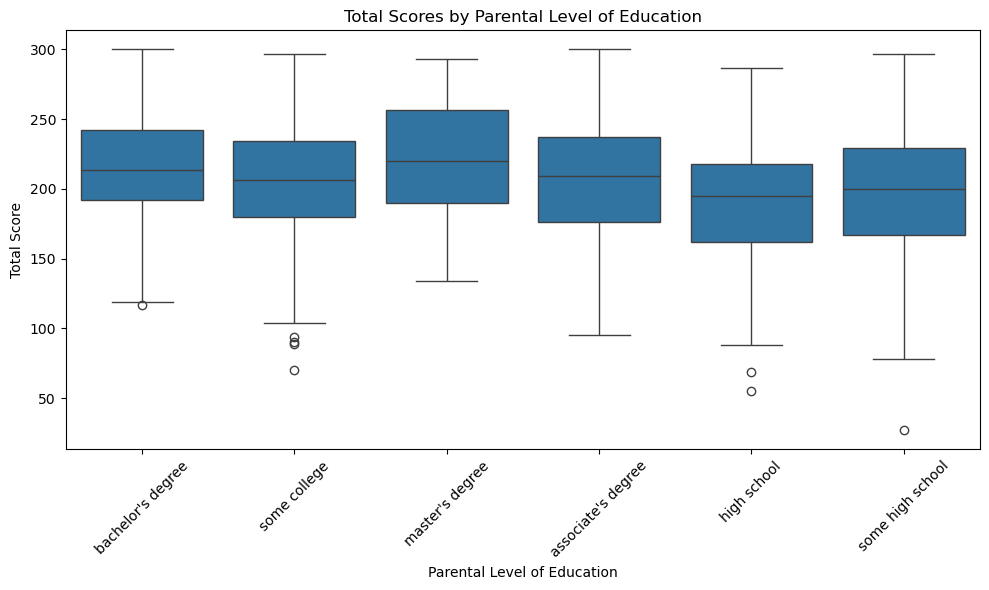

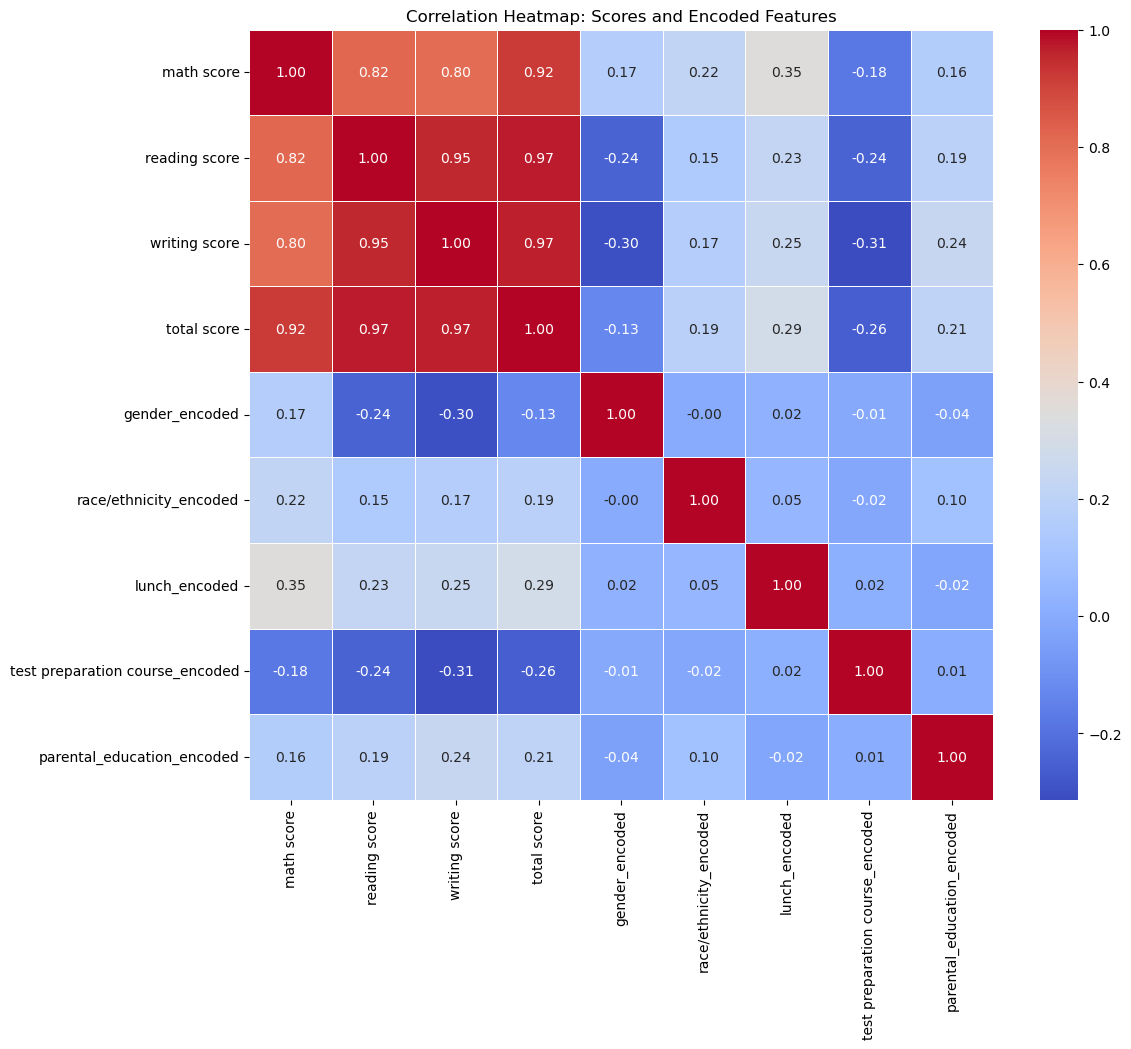

In [4]:
# Section 4: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# 4.1 Distribution of Scores
scores = ['math score', 'reading score', 'writing score', 'total score']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx, score in enumerate(scores):
    sns.histplot(student_data[score], bins=20, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {score.capitalize()}')
    axes[idx].set_xlabel(score.capitalize())
    axes[idx].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


# 4.2 Boxplots: Compare Scores by Key Categories

categorical_vars = ['gender', 'lunch', 'test preparation course']


fig, axes = plt.subplots(3, 4, figsize=(20, 18))

for i, cat_var in enumerate(categorical_vars):
    for j, score in enumerate(scores):
        sns.boxplot(data=student_data, x=cat_var, y=score, ax=axes[i][j])
        axes[i][j].set_title(f'{score.capitalize()} by {cat_var.capitalize()}')
        axes[i][j].set_xlabel(cat_var.capitalize())
        axes[i][j].set_ylabel(score.capitalize())

plt.tight_layout()
plt.show()

# Boxplot for total score by parental education (ordinal category)
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_data, x='parental level of education', y='total score')
plt.title('Total Scores by Parental Level of Education')
plt.xlabel('Parental Level of Education')
plt.xticks(rotation=45)
plt.ylabel('Total Score')
plt.tight_layout()
plt.show()

# 4.3 Correlation Heatmap (including raw scores and encoded categorical features)
# Define features to include in the heatmap
heatmap_features = ['math score', 'reading score', 'writing score', 'total score',
                    'gender_encoded', 'race/ethnicity_encoded', 'lunch_encoded',
                    'test preparation course_encoded', 'parental_education_encoded']
corr_matrix = student_data[heatmap_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Scores and Encoded Features')
plt.show()

Training set shape: (800, 5) (800, 4)
Validation set shape: (200, 5) (200, 4)
Best Parameters from Grid Search: {'estimator__max_depth': 5, 'estimator__min_samples_split': 20, 'estimator__n_estimators': 100}

Model Evaluation Metrics:
math score: MSE = 209.32, R² = 0.14
reading score: MSE = 189.81, R² = 0.16
writing score: MSE = 176.36, R² = 0.27
total score: MSE = 1647.67, R² = 0.15


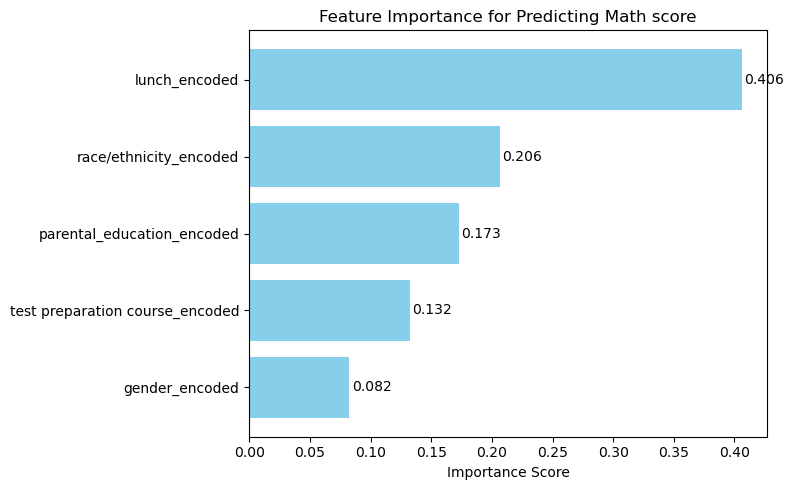

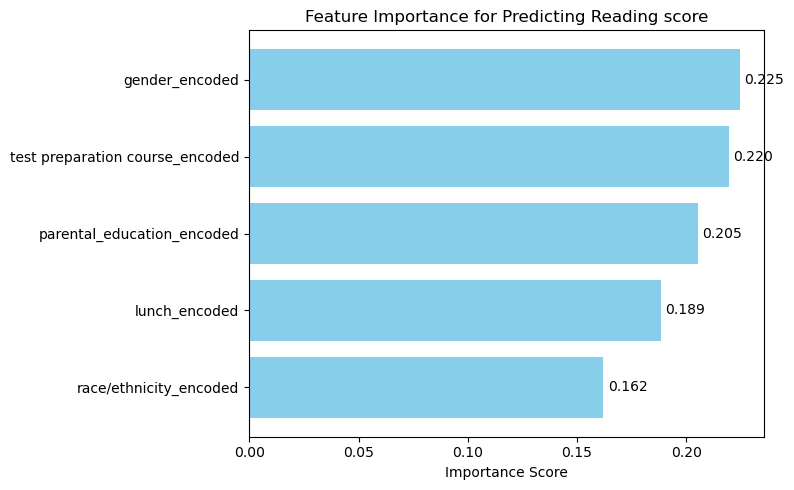

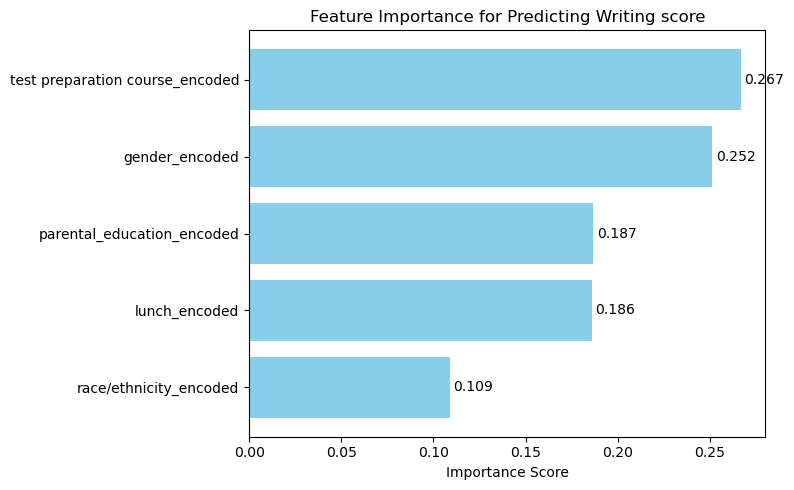

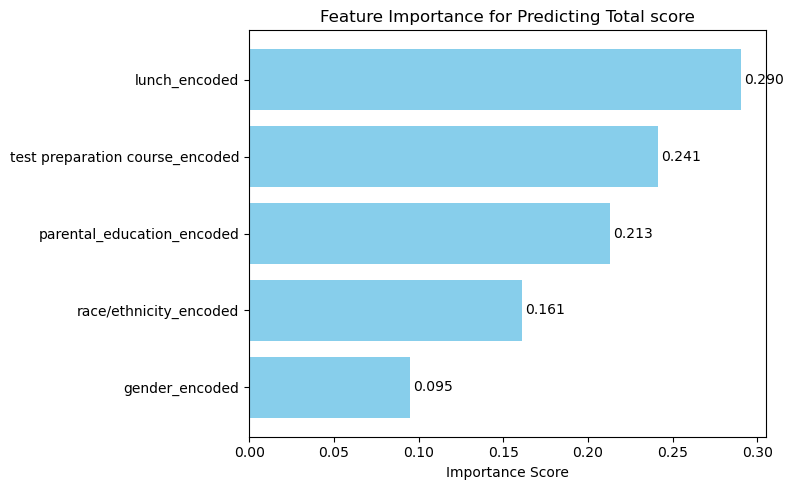

In [5]:
# Section 5: Model Building and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 5.1 Prepare Data for Modeling
# Define feature columns (encoded categorical variables) and target columns (scores)
features = ['gender_encoded', 'race/ethnicity_encoded', 'parental_education_encoded',
            'lunch_encoded', 'test preparation course_encoded']
targets = ['math score', 'reading score', 'writing score', 'total score']

X = student_data[features]
y = student_data[targets]

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

# 5.2 Model Training with Grid Search (Random Forest Regressor)
# Use MultiOutputRegressor to handle multiple continuous targets
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [5, 10, 15],
    'estimator__min_samples_split': [10, 15, 20]
}

# Set verbose=0 to suppress detailed log outputs
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print("Best Parameters from Grid Search:", grid_search.best_params_)

# 5.3 Evaluate the Best Model on the Validation Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

print("\nModel Evaluation Metrics:")
for i, target in enumerate(targets):
    mse = mean_squared_error(y_val[target], y_pred[:, i])
    r2 = r2_score(y_val[target], y_pred[:, i])
    print(f"{target}: MSE = {mse:.2f}, R² = {r2:.2f}")

# 5.4 Feature Importance Visualization for Each Target
for idx, target in enumerate(targets):
    importances = best_model.estimators_[idx].feature_importances_
    sorted_idx = np.argsort(importances)
    
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(features)[sorted_idx], importances[sorted_idx], color='skyblue')
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance for Predicting {target.capitalize()}')
    for i, v in enumerate(importances[sorted_idx]):
        plt.text(v + 0.002, i, f"{v:.3f}", va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

In [6]:
# Section 6: Additional Statistical Analysis
from scipy.stats import ttest_ind

# Compare math scores for students with 'standard' vs. 'free/reduced' lunch
standard_lunch = student_data[student_data['lunch'] == 'standard']['math score']
free_reduced_lunch = student_data[student_data['lunch'] == 'free/reduced']['math score']

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(standard_lunch, free_reduced_lunch)

print("\nT-test for Math Scores by Lunch Type:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference in math scores between lunch groups is statistically significant.")
else:
    print("No statistically significant difference found between the groups.")


T-test for Math Scores by Lunch Type:
t-statistic: 11.8372
p-value: 0.0000
The difference in math scores between lunch groups is statistically significant.


Key Findings:
- Socioeconomic status has a significant effect on academic performance; students receiving free/reduced lunch scored lower than those with standard lunch.
- Structured test preparation is positively associated with improved exam scores.
- Higher parental education correlates with better student performance, suggesting the importance of parental involvement in education.
